In [9]:
# Install required packages
%pip install imbalanced-learn xgboost -q


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support,
    balanced_accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")


In [11]:
train_df = pd.read_csv("../data/processed/train_processed.csv")
test_df = pd.read_csv("../data/processed/test_processed.csv")

print("Train shape:", train_df.shape, " Test shape:", test_df.shape)

target = "health_status"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Check class distribution
print("\n📊 Original Class Distribution:")
print("Training set:")
print(y_train.value_counts())
print(f"\nClass proportions:\n{y_train.value_counts(normalize=True)}")
print("\nTest set:")
print(y_test.value_counts())
print(f"\nClass proportions:\n{y_test.value_counts(normalize=True)}")

Train shape: (8000, 16)  Test shape: (2000, 16)

📊 Original Class Distribution:
Training set:
health_status
0    7616
1     370
2      14
Name: count, dtype: int64

Class proportions:
health_status
0    0.95200
1    0.04625
2    0.00175
Name: proportion, dtype: float64

Test set:
health_status
0    1904
1      93
2       3
Name: count, dtype: int64

Class proportions:
health_status
0    0.9520
1    0.0465
2    0.0015
Name: proportion, dtype: float64


In [12]:
# Apply SMOTE to balance classes
print("\n🔄 Applying SMOTE to balance classes...")
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n✅ Balanced Training Set Distribution:")
print(f"Original: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_train_balanced)}")

# Define models with class weight balancing as backup
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10, 
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, 
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        min_samples_split=10,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=7,
        min_child_weight=3,
        scale_pos_weight=10,  # Help with imbalance
        use_label_encoder=False, 
        eval_metric="mlogloss", 
        random_state=42
    )
}


🔄 Applying SMOTE to balance classes...

✅ Balanced Training Set Distribution:
Original: Counter({0: 7616, 1: 370, 2: 14})
After SMOTE: Counter({0: 7616, 1: 7616, 2: 7616})


In [13]:
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"🔹 Training {name}...")
    print('='*60)
    
    # Train on balanced data
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    
    # Calculate multiple metrics
    acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))


🔹 Training Logistic Regression...
Accuracy: 0.9100
Balanced Accuracy: 0.9208
F1-Score (Macro): 0.6550
F1-Score (Weighted): 0.9289

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1904
           1       0.32      0.85      0.47        93
           2       0.38      1.00      0.55         3

    accuracy                           0.91      2000
   macro avg       0.56      0.92      0.65      2000
weighted avg       0.96      0.91      0.93      2000


🔹 Training Decision Tree...
Accuracy: 0.9890
Balanced Accuracy: 0.8818
F1-Score (Macro): 0.8959
F1-Score (Weighted): 0.9895

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1904
           1       0.81      0.99      0.89        93
           2       1.00      0.67      0.80         3

    accuracy                           0.99      2000
   macro avg       0.94      0.88      


📊 MODEL COMPARISON - All Metrics
                     accuracy  balanced_accuracy  f1_macro  f1_weighted
XGBoost                0.9935             0.9943    0.9769       0.9937
Gradient Boosting      0.9960             0.8843    0.9188       0.9960
Decision Tree          0.9890             0.8818    0.8959       0.9895
Random Forest          0.9965             0.7735    0.8207       0.9963
Logistic Regression    0.9100             0.9208    0.6550       0.9289


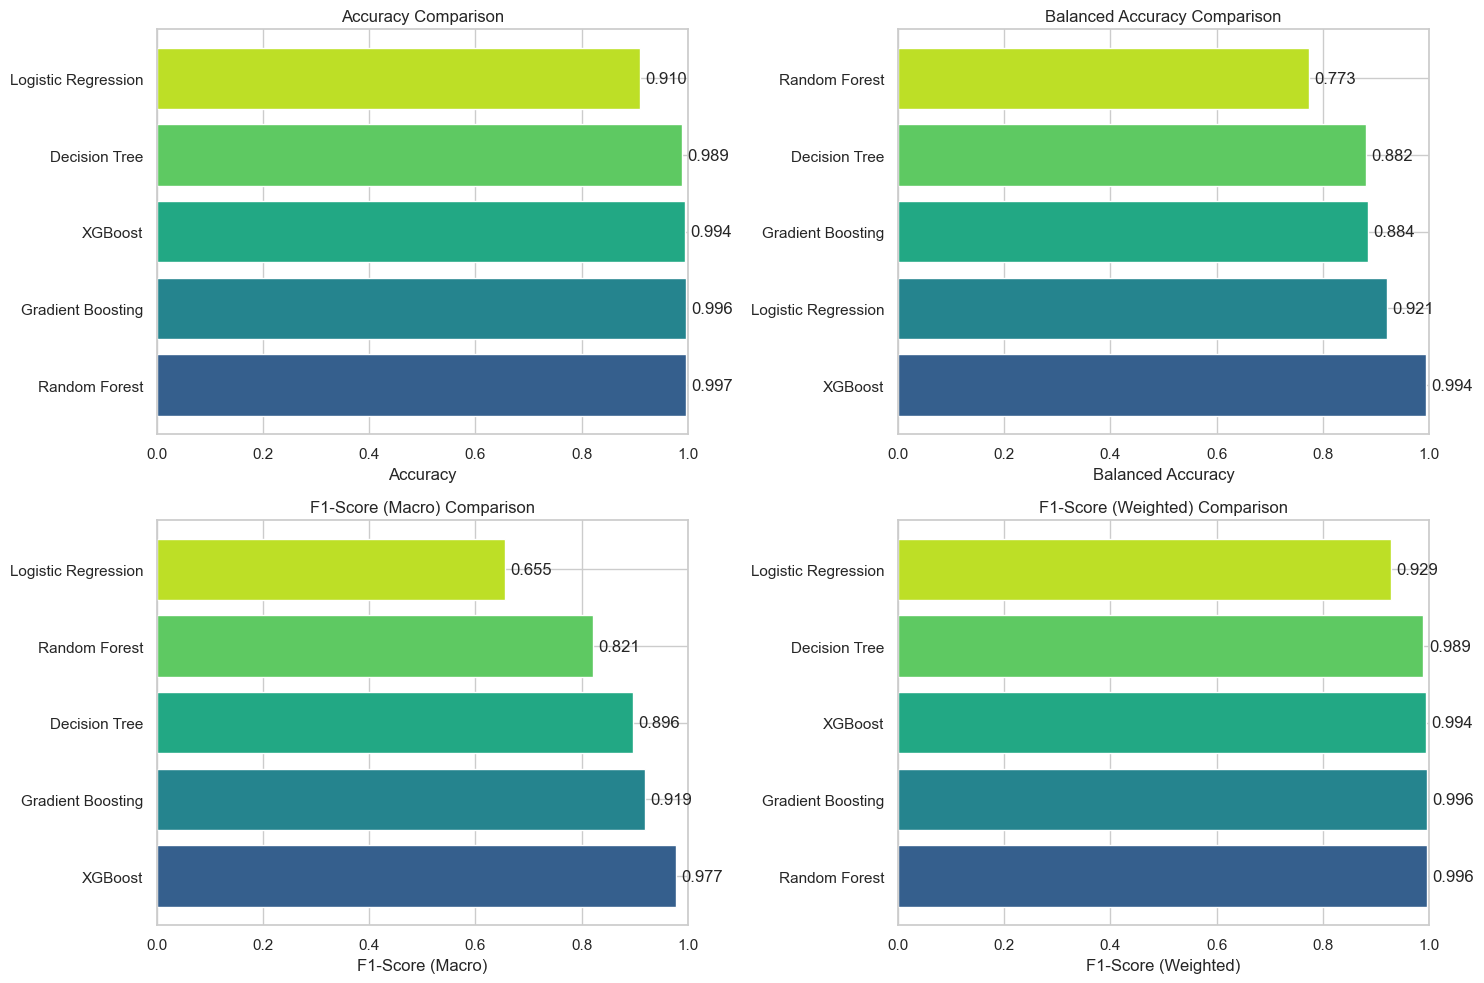


🏆 Best Model (by F1-Macro): XGBoost
   F1-Macro: 0.9769
   Balanced Accuracy: 0.9943


In [15]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df = results_df.sort_values(by="f1_macro", ascending=False)

print("\n" + "="*70)
print("📊 MODEL COMPARISON - All Metrics")
print("="*70)
print(results_df.round(4))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['accuracy', 'balanced_accuracy', 'f1_macro', 'f1_weighted']
titles = ['Accuracy', 'Balanced Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    sorted_results = results_df.sort_values(by=metric, ascending=False)
    # Generate colors from viridis colormap
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_results)))
    bars = ax.barh(sorted_results.index, sorted_results[metric], color=colors)
    ax.set_xlabel(title)
    ax.set_title(f'{title} Comparison')
    ax.set_xlim([0, 1])
    
    # Add value labels
    for i, v in enumerate(sorted_results[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print(f"\n🏆 Best Model (by F1-Macro): {results_df.index[0]}")
print(f"   F1-Macro: {results_df.iloc[0]['f1_macro']:.4f}")
print(f"   Balanced Accuracy: {results_df.iloc[0]['balanced_accuracy']:.4f}")

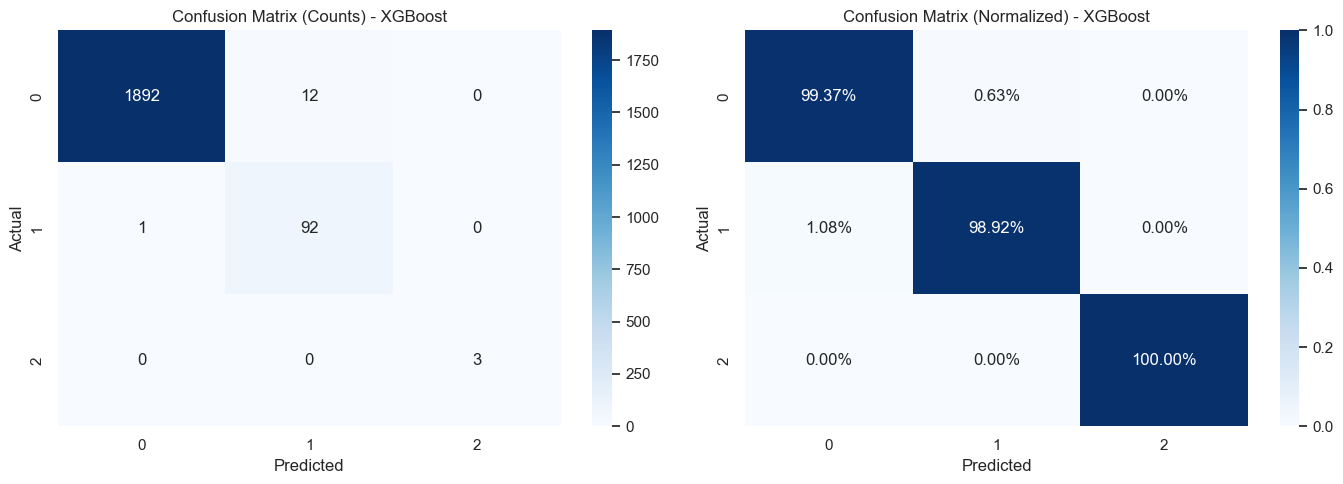


📈 Detailed Performance - XGBoost
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1904
           1       0.88      0.99      0.93        93
           2       1.00      1.00      1.00         3

    accuracy                           0.99      2000
   macro avg       0.96      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000



In [16]:
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

# Detailed confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_normalized = confusion_matrix(y_test, y_pred_best, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title(f"Confusion Matrix (Counts) - {best_model_name}")

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title(f"Confusion Matrix (Normalized) - {best_model_name}")

plt.tight_layout()
plt.show()

# Per-class performance
print("\n" + "="*60)
print(f"📈 Detailed Performance - {best_model_name}")
print("="*60)
print(classification_report(y_test, y_pred_best))

In [17]:
# Hyperparameter tuning for the best model
print("\n" + "="*70)
print("🔧 Hyperparameter Tuning for Best Model")
print("="*70)

if best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [12, 15, 18],
        'min_samples_split': [8, 10, 12],
        'min_samples_leaf': [3, 4, 5],
        'max_features': ['sqrt', 'log2']
    }
    tuned_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
    
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [150, 200, 250],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [5, 7, 9],
        'min_child_weight': [2, 3, 4],
        'scale_pos_weight': [5, 10, 15]
    }
    tuned_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
    
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [150, 200, 250],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [5, 7, 9],
        'min_samples_split': [8, 10, 12]
    }
    tuned_model = GradientBoostingClassifier(random_state=42)
else:
    param_grid = {}
    tuned_model = models[best_model_name]

if param_grid:
    # Use StratifiedKFold for imbalanced data
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # GridSearch with F1-macro as scoring metric (better for imbalanced data)
    grid_search = GridSearchCV(
        tuned_model, 
        param_grid, 
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\n⏳ Running GridSearchCV on {best_model_name}...")
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    print(f"\n✅ Best parameters: {grid_search.best_params_}")
    print(f"✅ Best CV F1-Macro: {grid_search.best_score_:.4f}")
    
    # Test the tuned model
    final_model = grid_search.best_estimator_
    y_pred_tuned = final_model.predict(X_test)
    
    print("\n" + "="*60)
    print("🎯 Tuned Model Performance on Test Set")
    print("="*60)
    print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_tuned):.4f}")
    print(f"F1-Score (Macro): {f1_score(y_test, y_pred_tuned, average='macro'):.4f}")
    print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_tuned, average='weighted'):.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred_tuned))
else:
    final_model = best_model
    print(f"\n⚠️ No hyperparameter tuning configured for {best_model_name}")
    print("Using the base model as final model.")



🔧 Hyperparameter Tuning for Best Model

⏳ Running GridSearchCV on XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

✅ Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 5}
✅ Best CV F1-Macro: 0.9979

🎯 Tuned Model Performance on Test Set
Accuracy: 0.9965
Balanced Accuracy: 0.9988
F1-Score (Macro): 0.9873
F1-Score (Weighted): 0.9966

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1904
           1       0.93      1.00      0.96        93
           2       1.00      1.00      1.00         3

    accuracy                           1.00      2000
   macro avg       0.98      1.00      0.99      2000
weighted avg       1.00      1.00      1.00      2000



In [18]:
# Save the final improved model
import joblib

model_path = "../outputs/models/final_health_risk_model.pkl"
joblib.dump(final_model, model_path)
print(f"\n💾 Final model saved to: {model_path}")

# Also save the SMOTE object for later use if needed
smote_path = "../outputs/models/smote_sampler.pkl"
joblib.dump(smote, smote_path)
print(f"💾 SMOTE sampler saved to: {smote_path}")

# Save model comparison results
results_df.to_csv("../outputs/reports/model_comparison.csv")
print(f"💾 Model comparison saved to: ../outputs/reports/model_comparison.csv")

print("\n" + "="*70)
print("✅ MODEL BUILDING COMPLETE")
print("="*70)
print(f"Final Model: {best_model_name}")
print(f"Training samples after SMOTE: {len(X_train_balanced)}")
print(f"Test samples: {len(X_test)}")
print("\n🎯 Key Improvements:")
print("  ✓ Applied SMOTE to handle class imbalance")
print("  ✓ Used class weights in models")
print("  ✓ Tuned hyperparameters with F1-macro scoring")
print("  ✓ Evaluated with balanced accuracy and F1-scores")
print("  ✓ Regularized models to prevent overfitting")



💾 Final model saved to: ../outputs/models/final_health_risk_model.pkl
💾 SMOTE sampler saved to: ../outputs/models/smote_sampler.pkl
💾 Model comparison saved to: ../outputs/reports/model_comparison.csv

✅ MODEL BUILDING COMPLETE
Final Model: XGBoost
Training samples after SMOTE: 22848
Test samples: 2000

🎯 Key Improvements:
  ✓ Applied SMOTE to handle class imbalance
  ✓ Used class weights in models
  ✓ Tuned hyperparameters with F1-macro scoring
  ✓ Evaluated with balanced accuracy and F1-scores
  ✓ Regularized models to prevent overfitting


In [19]:
if len(np.unique(y_test)) == 2:
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {best_model_name}")
    plt.legend()
    plt.show()